# Mixing in a homogeneous magnetic field

This tutorial demonstrates the most simple use case of the gammaALPs code, namely the mixing between photons and ALPs in a homogeneous magnetic field. The magnetic-field parameters are probably not very realisitic, but the results nicely illustrate some of the main features of photon-ALP mixing. 

We first import the relevant modules:

In [1]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base.transfer import EminGeV, EmaxGeV
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as c

And set the ALP parameters:

In [2]:
m, g = 10., 3.
alp = ALP(m, g)

Let's define an energy range for this example, in GeV.

In [3]:
EGeV = np.logspace(0.,8.,1000)

For the initial polarization, we use a fully polarized photon beam,

In [4]:
pin = np.diag((1., 0., 0.))

And we define some dummy source:

In [5]:
src = Source(z=0., l=0., b=0.)

With the defined `alp`, `src`, initial polarization `pin` and energy range `EGeV`, we can now initialize our module list

In [6]:
ml = ModuleList(alp, src, pin=pin, EGeV=EGeV, seed=0)

We add a single propagation enivironment, mixing in a cell-like field in a galaxy cluster. 
By setting `eta` and `beta` to zero, we force the electron density to be constant, so 
that neither the magnetic field nor the electron density change with propagation distance. 
We choose arbitrary values for B-field strength and electron density that give nice results for illustration. 

In [7]:
ml.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=1.,  # B field strength
                   L0=10.,  # cell size
                   nsim=1,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=10.1,  # full path, chosen that we only have a single cell
                   beta=0., 
                   eta=0.
                  )

Now we explicitly set the angle $\psi$ between the transversal magnetic field and the $x$ direction to $\pi / 2$ so that the $x$ polarization will fully mix. 

In [8]:
ml.modules[0].psin = np.ones_like(ml.modules[0].psin) * np.pi / 2.

We run the photon-ALP calculation to get the final oscillation probabilities into the two photon polarization states and into the ALP state

In [9]:
px, py, pa = ml.run()
print (pa.shape)

(1, 1000)


And plot the results:

Text(0, 0.5, '$P_{a\\gamma}$')

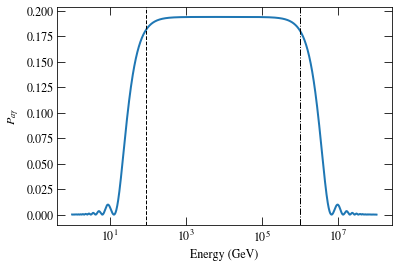

In [10]:
plt.semilogx(EGeV, pa[0], lw=2)

# the critical energy, onset of strong mixing regime
plt.axvline(EminGeV(m_neV=ml.alp.m, g11=ml.alp.g, BmuG=ml.modules[0].B, n_cm3=ml.modules[0].nel),
            lw=1., ls='--', color='k')

# maximum energy, end of strong mixing regime
plt.axvline(EmaxGeV(g11=ml.alp.g, BmuG=ml.modules[0].B),
            lw=1., ls='-.', color='k')

plt.xlabel("Energy (GeV)")
plt.ylabel("$P_{a\gamma}$")